# **Fair Minimum Representation Clustering with Column Generation**

In [1]:
import numpy as np
#import cvxpy as cp
#%pip install repliclust
#%pip install -i https://pypi.gurobi.com gurobipy;
import gurobipy as gp

In [2]:
from gurobipy import GRB
from repliclust import set_seed, Archetype, DataGenerator
import matplotlib.pyplot as plt

**Master problem**

\begin{align*}
&\textbf{min} & \sum_{k}r_kz_k & \\
&\textbf{s.t.} & \sum_{k \in C} s_{i,k}z_k &= 1, \forall i\\
&  \quad & \sum_{k \in C} t_{g,k}z_k &\geq \beta_g, \forall g \\
&  \quad & \sum_{k \in C} z_k &= K \\
&  \quad & z_k &\in \{0,1\}
\end{align*}

$k$: the $k$-th cluster of points

$g$: the group of points with label $g$

$C$: the set of all clusters

$r_k$ : sum of squared 2-norm of distances between points in cluster $k$ and the center of cluster $k$.

$z_k$ : decision variables that determine if a cluster is selected.

$\beta_g$: least number of $\alpha$ represented cluster for group $g$.

$s_{i,k}$: parameters that determine if point $i$ is in cluster $k$.

$t_{g,k}$: parameters that determine if cluster $k$ is $\alpha$-represented for group $g$.

**Pricing problem**

\begin{align}
&\textbf{min} &\space (\sum_{\forall i} r_i - \sum_{\forall i} \mu_is_i &- \sum_{\forall g} \lambda_gt_g)\\
&\textbf{s.t.} &\sum_{\forall i} q_{g,i}s_i + M(1-t_g) &\geq \alpha_g\sum_{\forall i} s_i, \forall g\\
& & r_i + M(1-s_i) &\geq ||x_i - c||_2^2, \forall i\\
& & u \geq \sum_{\forall i} s_i &\geq l, \forall i\\
& & r_i \geq 0, s_i, t_g \in \{0,1\}, c &\in \mathbb{R}^n
\end{align}

$s_i$ : decision variables determining if point $i$ is in the generated cluster.

$t_g$ : decision variables determining if the generated cluster is $\alpha$-represented for group $g$.

$r_i$ : decision variables for the contribution of squared 2-norm of point $i$ to the sum of distances between points and the center of cluster in the new cluster.

$c$ : decision variable for the center of the new cluster.

$\mu_i$ : dual variables for constraints \ref{eq:master-cons-1}.

$\lambda_g$ : dual variables for constraints \ref{eq:master-cons-2}.

$q_{g,i}$ : parameters that determine if point $i$ is in group $g$.

$u$ : upper bound for the number of points in a cluster

$l$ : lower bound for the number of points in a cluster

In [3]:
def master_optimize(model,m,n,l,Z):
    # Solve the problem
    model.optimize()

    # Print objective value
    print('Objective:', model.objVal)

    # Print variable values
    for i, var in enumerate(model.getVars()):
        print(f"{var.varName} = {var.x}")

    # Print dual variables
    print("Dual values:")
    for constr in model.getConstrs():
        print(f"{constr.ConstrName}: {constr.Pi}")

    constraints = list(model.getConstrs())

    mu = [cons_i.Pi for cons_i in constraints[:n]]

    lmd = [cons_g.Pi for cons_g in constraints[n:n+l]]

    delta = constraints[n+l].Pi

    # for cons_i in constraints[:n]:
    #   mu.append(cons_i.Pi)

    # lmd = []
    # for cons_g in constraints[n:n+l]:
    #   lmd.append(cons_g.Pi)

    optimal_values_Z = [int(Z[k].x) for k in range(m)]

    return mu, lmd, model.objVal, optimal_values_Z, delta, Z

In [4]:
def master_warm_start(model, Z, m, n, l, new_r, optimal_values_s, optimal_values_t):
  constrs = model.getConstrs()
  optimal_values_s.append(optimal_values_t) # new column
  optimal_values_s.append(1)
  new_z = model.addVar(vtype=GRB.CONTINUOUS, name="Z["+str(m)+"]", column = gp.Column(optimal_values_s,constrs[:n+l+1]))
  Z += new_z
  model.setObjective(model.getObjective() + new_z * new_r)

  return master_optimize(model,m,n,l,Z)

In [5]:
def solve_master_problem_gurobi(n, m, l, r, s, t, beta, K):
    # Create a Gurobi model
    model = gp.Model("MasterProblem")
    #model.Params.LogToConsole = 0

    # Create decision variables
    Z = model.addMVar(m, vtype=GRB.CONTINUOUS, name="Z")

    # Set objective function
    model.setObjective(gp.quicksum(Z[i] * r[i] for i in range(m)), GRB.MINIMIZE)

    # Constraints
    constraint1 = []
    constraint2 = []

    for i in range(n):
      constraint1.append(model.addConstr(gp.quicksum(s[k][i] * Z[k] for k in range(m)) == 1, name="Constraint1_"+str(i)))

    for g in range(l):
      constraint2.append(model.addConstr(gp.quicksum(t[g][k] * Z[k] for k in range(m)) >= beta[g], name="Constraint2_"+str(g)))

    constraint_3 = [model.addConstr(gp.quicksum(Z[k] for k in range(m)) == K, name="Constraint3")]

    for k in range(m):
        model.addConstr(Z[k] <= 1, name="Constraint4_"+str(k))
        model.addConstr(Z[k] >= 0, name="Constraint5_"+str(k))

    return master_optimize(model,m,n,l,Z)

In [6]:
def solve_master_problem_integer(n, m, l, r, s, t, beta, K):
    # Create a Gurobi model
    model = gp.Model("MasterProblemInteger")
    #model.Params.LogToConsole = 0

    # Create decision variables
    Z = model.addMVar(m, vtype=GRB.BINARY, name="Z")

    # Set objective function
    model.setObjective(gp.quicksum(Z[i] * r[i] for i in range(m)), GRB.MINIMIZE)

    # Constraints
    constraint1 = []
    constraint2 = []

    for i in range(n):
      constraint1.append(model.addConstr(gp.quicksum(s[k][i] * Z[k] for k in range(m)) == 1, name="Constraint1_"+str(i)))

    for g in range(l):
      constraint2.append(model.addConstr(gp.quicksum(t[g][k] * Z[k] for k in range(m)) >= beta[g], name="Constraint2_"+str(g)))

    constraint_3 = [model.addConstr(gp.quicksum(Z[k] for k in range(m)) == K, name="Constraint3")]

    # Solve the problem
    model.optimize()

    # Print objective value
    print('Objective:', model.objVal)

    # Print variable values
    for i, var in enumerate(model.getVars()):
        print(f"{var.varName} = {var.x}")

    optimal_values_Z = [int(Z[k].x) for k in range(m)]

    return model.objVal, optimal_values_Z

In [7]:
def solve_pricing_problem_gurobi(n, l, r, q, alpha, beta, delta, K, M, x, y, mu, lmd, lower, upper):
    # Create a Gurobi model
    model = gp.Model("PricingProblem")
    #model.Params.LogToConsole = 0

    # Create decision variables
    r = model.addMVar(n, vtype=GRB.CONTINUOUS, name="R")
    s = model.addMVar(n, vtype=GRB.BINARY, name="S")
    t = model.addMVar(l, vtype=GRB.BINARY, name="t")
    cx = model.addVar(vtype=GRB.CONTINUOUS, lb = -100, name="cx")
    cy = model.addVar(vtype=GRB.CONTINUOUS, lb = -100, name="cy")

    # Objective function

    objective = gp.quicksum(r[i] for i in range(n)) \
                - gp.quicksum(mu[i] * s[i] for i in range(n)) \
                - gp.quicksum(lmd[g] * t[g] for g in range(l)) \
                - delta
    model.setObjective(objective , GRB.MINIMIZE)

    # Constraints
    constraints = []

    for g in range(l):
      constraints.append(model.addConstr(gp.quicksum(q[g][i] * s[i] for i in range(n)) + M*(1-t[g]) >= alpha * gp.quicksum(s[i] for i in range(n)), name="Constraint1"))

    for i in range(n):
      constraints.append(model.addConstr(r[i] + M*(1-s[i]) >= (x[i] - cx)**2 + (y[i] - cy)**2, name="Constraint2"))
      constraints.append(model.addConstr(r[i] >= 0, name="Constraint3"))

    constraints.append(model.addConstr(gp.quicksum(s[i] for i in range(n)) >= lower, name="Constraint3"))
    constraints.append(model.addConstr(gp.quicksum(s[i] for i in range(n)) <= upper, name="Constraint4"))

    # Solve the problem
    model.optimize()

    # Print objective value
    print('Objective:', model.objVal)

    # Print variable values
    for var in model.getVars():
      print(f"{var.varName} = {var.x}")

    # Print constraints
    # for constr in constraints:
    #   print(constr)

    optimal_values_s = [int(np.round(s[i].x)) for i in range(n)]
    optimal_values_r = [float(r[i].x) for i in range(n)]
    optimal_values_t = [int(np.round(t[g].x)) for g in range(l)]
    optimal_center = (cx.x,cy.x)

    return model.objVal, optimal_values_s, optimal_values_r, optimal_values_t, optimal_center

In [16]:
def main_loop(iterations,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y,optimal_centers):
  reduced_cost = 1
  counter = 1
  model = None
  Z = None
  objectives = []
  while counter < iterations:
    print("Iteration #"+str(counter))
    print("s:",s)
    print("r:",r)
    print("t:",t)
    counter += 1
    if not model:
      mu, lmd, masterobj, optimal_values_Z, delta, Z = solve_master_problem_gurobi(n, m, l, r, s, t, beta, K)
      objectives.append(masterobj)
    else:
      mu, lmd, masterobj, optimal_values_Z, delta, Z = master_warm_start(model, Z, m, n, l, new_r, optimal_values_s, optimal_values_t)
      objectives.append(masterobj)
    reduced_cost, optimal_values_s, optimal_values_r, optimal_values_t, optimal_center = solve_pricing_problem_gurobi(n, l, r, q, alpha, beta, delta, K, M, x, y, mu, lmd, lower, upper)
    optimal_centers.append(optimal_center)
    print("New cluster found")
    print(optimal_values_s)
    if reduced_cost >= -1e-4:
      print("Terminate")
      print("Number of iterations", counter)
      print("Objective:",masterobj)
      print("Z:")
      print(optimal_values_Z)
      print("s:")
      print(s)
      print("Clusters:")
      for i in range(len(s)):
        if optimal_values_Z[i] > 0:
          print(s[i])
      break
    if optimal_values_s in s:
      #raise Exception("Error: Repetition")
      print("Repetition found. Terminate.")
      print("Number of iterations", counter)
      print("Objective:",masterobj)
      print("Z:")
      print(optimal_values_Z)
      print("s:")
      print(s)
      print("Clusters:")
      for i in range(len(s)):
        if optimal_values_Z[i] > 0:
          print(s[i])
      break
    s.append(optimal_values_s)
    new_r = sum(optimal_values_r)
    r.append(new_r)
    for g in range(l):
      t[g].append(optimal_values_t[g])
    m += 1

  masterobj, optimal_values_Z = solve_master_problem_integer(n, m, l, r, s, t, beta, K)

  return s, r, t, masterobj, optimal_values_Z, optimal_centers, objectives
  

In [144]:
K = 2
n = 5
m = 6
l = 2
r = [0.5, 8/3, 1, 0.5, 1, 1]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1],
              [0, 0, 1, 0, 1],
              [0, 0, 1, 1, 0]]
t =          [[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 1, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(8,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y,[])

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0]]
r: [0.5, 2.6666666666666665, 1, 0.5, 1, 1]
t: [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 6 columns and 35 nonzeros
Model fingerprint: 0x267b656a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 20 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work uni

([[1, 1, 0, 0, 0],
  [0, 0, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [0, 1, 0, 0, 1],
  [0, 0, 1, 0, 1],
  [0, 0, 1, 1, 0],
  [0, 0, 0, 1, 1],
  [1, 1, 0, 0, 1]],
 [0.5,
  2.6666666666666665,
  1,
  0.5,
  1,
  1,
  2.0000000046475472,
  1.3333333635408682],
 [[1, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 1, 0, 0]],
 2.333333363540868,
 [0, 0, 0, 0, 0, 1, 0, 1],
 [(4.369694973823059e-06, -8.413116754817605e-06),
  (0.33331164491096243, 0.33331164491096243),
  (0.3334948970919991, 0.333301547365091)])

In [145]:
K = 2
n = 5
m = 5
l = 2
r = [0.5, 8/3, 1, 0.5, 1]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1],
              [0, 0, 1, 1, 0]]
t =          [[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(20,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y,[])

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 1, 0]]
r: [0.5, 2.6666666666666665, 1, 0.5, 1]
t: [[1, 0, 0, 0, 0], [0, 1, 0, 0, 1]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 18 rows, 5 columns and 29 nonzeros
Model fingerprint: 0x93e42048
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 18 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.1

([[1, 1, 0, 0, 0],
  [0, 0, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [0, 1, 0, 0, 1],
  [0, 0, 1, 1, 0],
  [1, 1, 0, 0, 1],
  [1, 1, 1, 0, 1],
  [1, 1, 0, 1, 1],
  [0, 1, 1, 0, 1],
  [0, 0, 1, 0, 1],
  [1, 1, 0, 1, 0]],
 [0.5,
  2.6666666666666665,
  1,
  0.5,
  1,
  1.3333333635401876,
  2.750000010301573,
  2.7500000103012043,
  1.3333333812947257,
  1.000000000705258,
  1.333333357107822],
 [[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]],
 2.333333363540188,
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [(0.3333116448788152, 0.3333116448788152),
  (0.2500173736561422, 1.1736145910190425e-05),
  (1.1736145930222781e-05, 0.2500173735067045),
  (0.3333117326918064, -0.33341970482729416),
  (0.49998638013347163, -0.4999870220913318),
  (-0.3334197047881786, 0.3333117326526778),
  (-0.3338107267109796, 0.33380865486576666)])

In [146]:
K = 2
n = 5
m = 4
l = 2
r = [0.5, 8/3, 1, 0.5]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 0, 0, 1]]
t =          [[1, 0, 0, 0],
              [0, 1, 0, 0]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(20,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y,[])

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1]]
r: [0.5, 2.6666666666666665, 1, 0.5]
t: [[1, 0, 0, 0], [0, 1, 0, 0]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16 rows, 4 columns and 23 nonzeros
Model fingerprint: 0x4a5417d0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 16 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.166666667e+00
Objective: 3.

([[1, 1, 0, 0, 0],
  [0, 0, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [0, 1, 0, 0, 1],
  [0, 1, 1, 0, 0],
  [0, 1, 0, 1, 0],
  [0, 0, 1, 1, 0],
  [1, 1, 0, 0, 1],
  [1, 1, 1, 1, 1],
  [0, 1, 1, 0, 1],
  [1, 1, 0, 1, 0],
  [0, 0, 1, 0, 1]],
 [0.5,
  2.6666666666666665,
  1,
  0.5,
  0.5000001279087618,
  0.5000001279087639,
  1.0000000072731883,
  1.3333333635401876,
  4.000001502166772,
  1.3333333812947257,
  1.333333381294728,
  1.0000000007058898],
 [[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]],
 2.333333370813376,
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
 [(1.201573136327113e-05, -0.500186811933676),
  (-0.5001868119590904, 1.2015731363966341e-05),
  (-0.4999909537128189, -0.4999909537128188),
  (0.3333116448788152, 0.3333116448788152),
  (6.223768220367713e-05, 6.223768220369728e-05),
  (0.3333117326918064, -0.33341970482729416),
  (-0.3334197047881786, 0.3333117326526778),
  (0.49998638013347163, -0.4999870220913318),
  (-0.33355054873267653, 0.3328798082655815)

In [148]:
K = 2
n = 5
m = 2
l = 2
r = [0.5, 8/3]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1]]
t =          [[1, 0],
              [0, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
x = [0,0,0,-1,1]
y = [1,0,-1,0,0]

main_loop(20,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,x,y,[])

Iteration #1
s: [[1, 1, 0, 0, 0], [0, 0, 1, 1, 1]]
r: [0.5, 2.6666666666666665]
t: [[1, 0], [0, 1]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)



CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12 rows, 2 columns and 13 nonzeros
Model fingerprint: 0xc5b5ffd3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1666667e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.166666667e+00
Objective: 3.1666666666666665
Z[0] = 1.0
Z[1] = 1.0
Dual values:
Constraint1_0: 0.5
Constraint1_1: 0.0
Constraint1_2: 2.6666666666666665
Constraint1_3: 0.0
Constraint1_4: 0.0
Constraint2_0: 0.0
Constraint2_1: 0.0
Constraint3: 0.0
Constraint4_0: 0.0
Constraint5_0: 0.0
Constraint4_1: 0.0
Constraint5_1: 0.0
Gurobi Optimizer version 11.

([[1, 1, 0, 0, 0],
  [0, 0, 1, 1, 1],
  [0, 1, 1, 0, 0],
  [1, 0, 0, 1, 0],
  [0, 1, 0, 0, 1],
  [0, 0, 1, 1, 0],
  [1, 1, 0, 0, 1],
  [0, 0, 1, 0, 1],
  [0, 0, 0, 1, 1],
  [1, 1, 1, 1, 1]],
 [0.5,
  2.6666666666666665,
  0.5000001279087618,
  1.0000000354172007,
  0.500000208113732,
  1.0000000072731883,
  1.333333336151754,
  1.0,
  2.000000004647741,
  4.000001502166772],
 [[1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]],
 2.3333333434249424,
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [(1.201573136327113e-05, -0.500186811933676),
  (-0.49998702208766016, 0.49998638012979996),
  (0.5000513829818131, -0.00010699674570996934),
  (-0.4999909537128189, -0.4999909537128188),
  (0.3333116448788152, 0.3333116448788152),
  (0.5, -0.5),
  (4.369695268424084e-06, -8.413117322197598e-06),
  (6.223768220367713e-05, 6.223768220369728e-05),
  (0.3333116448788152, 0.3333116448788152)])



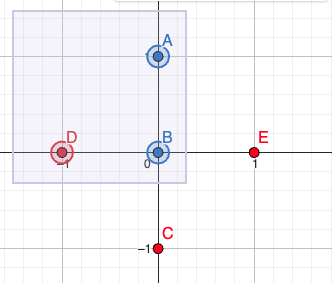

## Synthetic data for clustering

Generate initial clusters

In [83]:
n = 30
K = 5
set_seed(5)

archetype = Archetype(n_clusters=K, dim=2, n_samples=n,
                             aspect_ref=1, aspect_maxmin=1, radius_maxmin=1, max_overlap = 0.02, min_overlap = 0.01)
data_generator = DataGenerator(archetype=archetype)
X, Y, archetype = data_generator.synthesize()

# fig, ax = plt.subplots(figsize=(6,6), dpi=150)
# ax.scatter(X[:,0], X[:,1], c=Y, s=15, alpha=0.5, linewidth=1.0)
# plt.title("Synthetic Data from Archetype '"
#             + archetype.name + "'")
# plt.xlabel('X1')
# plt.ylabel('X2').set_rotation(0)
# plt.axis('equal');

Optimizing Cluster Centers: 100%|██████████| 300/300 [00:00<00:00, 11713.64it/s, Status=SUCCESS]


In [85]:
clusters_assign_random = np.random.choice(list(range(K)), size=n)

xc = [0 for _ in range(K)]
yc = [0 for _ in range(K)]
cluster_size = [0 for _ in range(K)]

for i in range(n):
  k = int(clusters_assign_random[i])
  cluster_size[k] += 1
  xc[k] += X[i][0]
  yc[k] += X[i][1]

for k in range(K):
  xc[k] /= cluster_size[k]
  yc[k] /= cluster_size[k]

dist = [0 for _ in range(K)]

for i in range(n):
  k = int(clusters_assign_random[i])
  dist[k] += (X[i][0] - xc[k]) **2 + (X[i][1] - yc[k]) **2

centers = [(xc[i],yc[i]) for i in range(K)]

print(clusters_assign_random)
print(centers)
print(dist)

[2 1 2 0 4 2 0 3 2 4 3 2 3 4 2 2 1 3 0 2 1 0 2 1 2 1 0 2 2 0]
[(-1.3611171660298453, 1.916378964202967), (-0.3586624455966887, 1.9881785688511904), (0.18894220477429577, 0.33870795500323486), (0.7302768328970108, -0.6372952918964523), (2.5924723978242126, -3.1604602420903434)]
[81.16775514921599, 75.15645617101494, 266.82924823868376, 139.63003403095584, 77.8490897704514]


In [178]:
# fig, ax = plt.subplots(figsize=(6,6), dpi=150)
# ax.scatter(X[:,0], X[:,1], c=clusters_assign_random, s=15, alpha=0.5, linewidth=1.0)
# ax.scatter(xc, yc, marker='P', c=list(range(K)), s=50, linewidth=1.0)

# plt.title("Initial Clusters")
# plt.xlabel('X1')
# plt.ylabel('X2').set_rotation(0)
# plt.axis('equal')

In [86]:
labels = np.random.choice([0,1,2], p= [0.1,0.2,0.7], size=n)

# fig, ax = plt.subplots(figsize=(6,6), dpi=150)
# ax.scatter(X[:,0], X[:,1], c=labels, s=15, alpha=0.5, linewidth=1.0)

# plt.title("Labels")
# plt.xlabel('X1')
# plt.ylabel('X2').set_rotation(0)
# plt.axis('equal')

In [87]:
clusters_random = [[0 for _ in range(n)] for _ in range(K)]
for i in range(n):
  k = int(clusters_assign_random[i])
  clusters_random[k][i] = 1
print(clusters_random)

[[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [88]:
l = 3
q = [[0 for _ in range(n)] for _ in range(l)]
for i in range(n):
  label = int(labels[i])
  q[label][i] = 1
print(q)

[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]]


In [89]:
alpha = 1/4
label_stats = [[0 for _ in range(K)] for _ in range(l)]
t = [[0 for _ in range(K)] for _ in range(l)]
for i in range(n):
  label = int(labels[i])
  k = int(clusters_assign_random[i])
  label_stats[label][k] += 1

print(label_stats)
print(cluster_size)

for i in range(l):
  for k in range(K):
    if label_stats[i][k] >= alpha * cluster_size[k]:
      t[i][k] = 1

print(t)

[[1, 0, 0, 1, 0], [1, 1, 0, 1, 0], [4, 4, 12, 2, 3]]
[6, 5, 12, 4, 3]
[[0, 0, 0, 1, 0], [0, 0, 0, 1, 0], [1, 1, 1, 1, 1]]


Helper functions

In [58]:
def solve_initial_feasible_solution(n, l, alpha, beta, K, M, lower, upper, group_info):
    # Create a Gurobi model
    model = gp.Model("PricingProblem")
    #model.Params.LogToConsole = 0

    # Create decision variables
    Z = model.addMVar((n,K), vtype=GRB.BINARY, name="Z")
    y = model.addMVar((l,K), vtype=GRB.BINARY, name="Y")

    # Objective function
    model.setObjective(0, GRB.MINIMIZE)

    # Constraints
    constraints = []

    for i in range(n):
      model.addConstr(gp.quicksum(Z[i][k] for k in range(K)) == 1)

    for g in range(l):
      for k in range(K):
        model.addConstr(gp.quicksum(Z[i][k] for i in group_info[g]) + M*(1-y[g][k]) >= alpha * gp.quicksum(Z[i][k] for i in range(n)))

    for g in range(l):
      model.addConstr(gp.quicksum(y[g][k] for k in range(K)) >= beta[g])

    for k in range(K):
      model.addConstr(gp.quicksum(Z[i][k] for i in range(n)) >= lower)
      model.addConstr(gp.quicksum(Z[i][k] for i in range(n)) <= upper)

    # Solve the problem
    model.optimize()

    # Print objective value
    print('Objective:', model.objVal)

    # Print variable values
    for var in model.getVars():
      print(f"{var.varName} = {var.x}")

    # Print constraints
    # for constr in constraints:
    #   print(constr)

    return model.objVal, Z.x, y.x

In [69]:
K = 2
n = 5
m = 2
l = 2
r = [0.5, 8/3]
beta = [1,1]
#              A, B, C, D, E
s =          [[1, 1, 0, 0, 0],
              [0, 0, 1, 1, 1]]
t =          [[1, 0],
              [0, 1]]
alpha = 2/3
M = 1e3
q = [[1, 1, 0, 0, 0],[0, 0, 1, 1, 1]]
lower = 2
upper = n
group_info = [{0,1},{2,3,4}]

obj,clusters,alpharep = solve_initial_feasible_solution(n, l, alpha, beta, K, M, lower, upper, group_info)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15 rows, 14 columns and 58 nonzeros
Model fingerprint: 0xf2165d8e
Variable types: 0 continuous, 14 integer (14 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Objective: 0.0
Z[0,0] = 0.0
Z[0,1] = 1.0
Z[1,0] = 0.0
Z[1,1] = 1.0
Z[2,0] = 1.0
Z[2,1] = 0.0
Z[3,0] = 0.0
Z[3,1] = 1.0
Z[4,0] = 1.0
Z[4,1] = 0.0
Y[0,0] = 0.0
Y[0,1] = 1.0
Y[1,0] = 1.0
Y[1,1] = 0.0


In [77]:
clusters.T.astype(int).tolist()

[[0, 0, 1, 0, 1], [1, 1, 0, 1, 0]]

In [9]:
def synthetic_data(n,K,seed):
  set_seed(seed)
  archetype = Archetype(n_clusters=K, dim=2, n_samples=n,
                             aspect_ref=1, aspect_maxmin=1, radius_maxmin=1, max_overlap = 0.02, min_overlap = 0.01)
  data_generator = DataGenerator(archetype=archetype)
  X, Y, archetype = data_generator.synthesize()
  return X,Y,archetype

In [68]:
np.random.choice([0,1,2], p= [0.1,0.2,0.7], size=n)

array([1, 2, 2, 0, 2])

In [ ]:
def initialize_clusters(X,K,l,alpha,beta,n,labels,M,lower,upper):
  #Set up labels info
  group_info = [set() for _ in range(l)]
  for i in range(labels):
    group_info[int(labels[i])].add(i)
  
  #Initialize feasible solution
  obj,clusters,alpharep = solve_initial_feasible_solution(n, l, alpha, beta, K, M, lower, upper, group_info)

  #Calculate initial centers
  clusters_assign_random = np.random.choice(list(range(K)), size=n)
  xc = [0 for _ in range(K)]
  yc = [0 for _ in range(K)]
  cluster_size = [0 for _ in range(K)]

  for i in range(n):
    k = int(clusters_assign_random[i])
    cluster_size[k] += 1
    xc[k] += X[i][0]
    yc[k] += X[i][1]

  for k in range(K):
    xc[k] /= cluster_size[k]
    yc[k] /= cluster_size[k]

  dist = [0 for _ in range(K)]

  for i in range(n):
    k = int(clusters_assign_random[i])
    dist[k] += (X[i][0] - xc[k]) **2 + (X[i][1] - yc[k]) **2

  centers = [(xc[i],yc[i]) for i in range(K)]

  # Randomly assigning labels
  clusters_random = [[0 for _ in range(n)] for _ in range(K)]
  for i in range(n):
    k = int(clusters_assign_random[i])
    clusters_random[k][i] = 1

  # Initialize q
  q = [[0 for _ in range(n)] for _ in range(l)]
  for i in range(n):
    label = int(labels[i])
    q[label][i] = 1

  # Initialize t
  label_stats = [[0 for _ in range(K)] for _ in range(l)]
  t = [[0 for _ in range(K)] for _ in range(l)]
  for i in range(n):
    label = int(labels[i])
    k = int(clusters_assign_random[i])
    label_stats[label][k] += 1

  for i in range(l):
    for k in range(K):
      if label_stats[i][k] >= alpha * cluster_size[k]:
        t[i][k] = 1

  return centers, dist, q, clusters_random, t

In [10]:
def initialize_clusters_random(X,K,l,alpha,n,labels):
  #Calculate initial centers
  clusters_assign_random = np.random.choice(list(range(K)), size=n)
  xc = [0 for _ in range(K)]
  yc = [0 for _ in range(K)]
  cluster_size = [0 for _ in range(K)]

  for i in range(n):
    k = int(clusters_assign_random[i])
    cluster_size[k] += 1
    xc[k] += X[i][0]
    yc[k] += X[i][1]

  for k in range(K):
    xc[k] /= cluster_size[k]
    yc[k] /= cluster_size[k]

  dist = [0 for _ in range(K)]

  for i in range(n):
    k = int(clusters_assign_random[i])
    dist[k] += (X[i][0] - xc[k]) **2 + (X[i][1] - yc[k]) **2

  centers = [(xc[i],yc[i]) for i in range(K)]

  # Randomly assigning labels
  clusters_random = [[0 for _ in range(n)] for _ in range(K)]
  for i in range(n):
    k = int(clusters_assign_random[i])
    clusters_random[k][i] = 1

  # Initialize q
  q = [[0 for _ in range(n)] for _ in range(l)]
  for i in range(n):
    label = int(labels[i])
    q[label][i] = 1

  # Initialize t
  label_stats = [[0 for _ in range(K)] for _ in range(l)]
  t = [[0 for _ in range(K)] for _ in range(l)]
  for i in range(n):
    label = int(labels[i])
    k = int(clusters_assign_random[i])
    label_stats[label][k] += 1

  for i in range(l):
    for k in range(K):
      if label_stats[i][k] >= alpha * cluster_size[k]:
        t[i][k] = 1

  return centers, dist, q, clusters_random, t

In [82]:
t

[[1, 0], [0, 1]]

In [24]:
n = 30
K = 5
seed = 5
l = 3
alpha = 1/4
labels = np.random.choice([0,1,2], p= [0.1,0.2,0.7], size=n)

X,Y,archetype = synthetic_data(n,K,seed)
centers, dist, q, clusters_random, t = initialize_clusters(X,K,l,alpha,n,labels)

r = dist.copy()
s = clusters_random.copy()
beta = [1,1,0]
M = 1e5
lower = 2
upper = n
m = K

s, r, t, masterobj, optimal_values_Z, centers, objectives = main_loop(200,K,n,m,l,r,beta,s,t,alpha,M,q,lower,upper,X[:,0],X[:,1],centers)

Optimizing Cluster Centers: 100%|██████████| 300/300 [00:00<00:00, 15810.26it/s, Status=SUCCESS]

Iteration #1
s: [[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
r: [71.34989860590791, 79.32551453831552, 176.30730079774258, 0.0, 278.59642674126064]
t: [[1, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 1, 1, 1, 1]]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 44 rows, 5 columns and 53 nonzeros
Model fingerprint: 0xc9e50869
Coefficient statistics:
  Mat

     0     0 -574.55751    0    - -573.17393 -574.55751  0.24%     -    0s
     0     0 -573.68932    0    - -573.17393 -573.68932  0.09%     -    0s
     0     0 -573.59975    0    - -573.17393 -573.59975  0.07%     -    0s
     0     0 -573.27775    0    - -573.17393 -573.27775  0.02%     -    0s
     0     0 -573.24811    0    - -573.17393 -573.24811  0.01%     -    0s

Explored 1 nodes (19 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: -573.174 

Optimal solution found (tolerance 1.00e-04)
Best objective -5.731739280902e+02, best bound -5.732170099222e+02, gap 0.0075%
Objective: -573.173928090152
R[0] = 2.434417230342596
R[1] = 5.3675617152717585
R[2] = 1.5109581119824034
R[3] = 0.0
R[4] = 23.09227553547788
R[5] = 0.0
R[6] = 0.0
R[7] = 0.0
R[8] = 0.0
R[9] = 0.0
R[10] = 0.0
R[11] = 0.0
R[12] = 0.0
R[13] = 0.0
R[14] = 0.0
R[15] = 0.0
R[16] = 0.0
R[17] = 0.0
R[18] = 0.0
R[19] = 0.0
R[20] = 0.0
R[21] = 0.0
R[22] =

In [25]:
len(s)

204

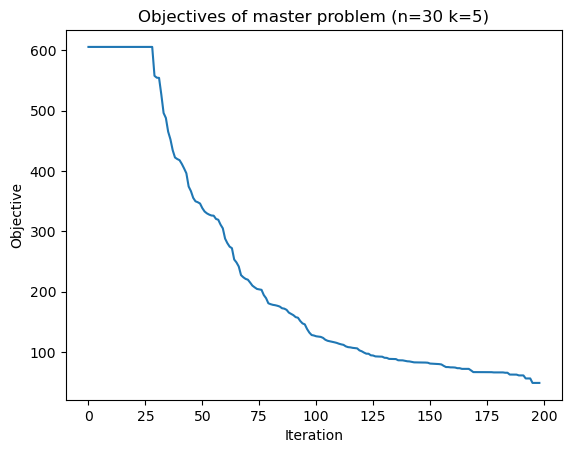

In [31]:
plt.plot(objectives)
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objectives of master problem (n=30 k=5)")
plt.show()

In [27]:
optimal_clusters = []
optimal_labels = [0 for _ in range(n)]
optimal_centers = []
counter = 0
for i,clust in enumerate(optimal_values_Z):
  if clust == 1:
    optimal_clusters.append(s[i])
    for j in range(n):
      if s[i][j] == 1:
        optimal_labels[j] = counter
    counter += 1
    optimal_centers.append(centers[i])


print(optimal_labels)
print(optimal_centers)

[4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 4, 1, 4, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
[(-4.171432506236237, -0.7984910149490323), (7.082242341456976, -2.83832489632634), (-3.152687523934858, 5.0513516448261), (-0.11698843687211946, 1.275732967368749), (3.2150233058112967, -3.013622046984916)]


(-5.616949342878313, 8.823006340340918, -5.897258019622055, 6.391378937925549)

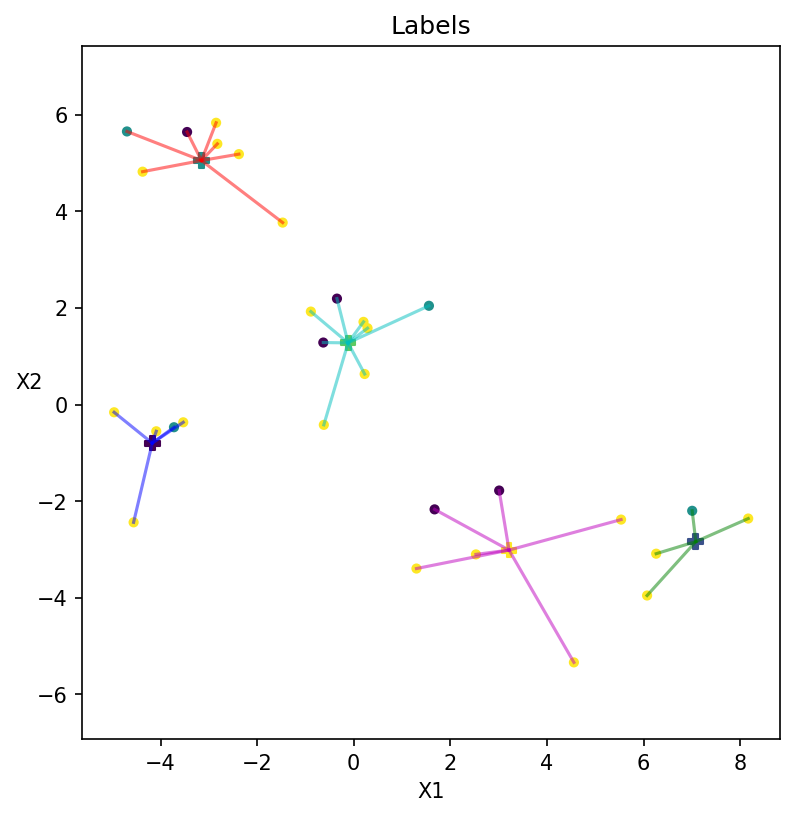

In [28]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
ax.scatter(X[:,0], X[:,1], c=labels, s=15, linewidth=1.0)
xc = [i[0] for i in optimal_centers]
yc = [i[1] for i in optimal_centers]
ax.scatter(xc, yc, marker='P', c=list(range(K)), s=50, linewidth=1.0)
for i in range(n):
  x = (X[i,0],optimal_centers[optimal_labels[i]][0])
  y = (X[i,1],optimal_centers[optimal_labels[i]][1])
  ax.plot(x,y, c = colors[optimal_labels[i]], alpha = 0.5)

plt.title("Labels")
plt.xlabel('X1')
plt.ylabel('X2').set_rotation(0)
plt.axis('equal')